# 0. Magic Commands


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Import Library

In [2]:
from fastai import *
from fastai.collab import *
from fastai.tabular import *

# 2. ข้อมูล

MovieLens 100K Dataset

MovieLens 100K movie ratings. Stable benchmark dataset. 100,000 ratings from 1000 users on 1700 movies. Released 4/1998. 

This data set consists of:
	* 100,000 ratings (1-5) from 943 users on 1682 movies. 
	* Each user has rated at least 20 movies. 
        * Simple demographic info for the users (age, gender, occupation, zip)



รัน cell ด้านล่างเพื่อดาวน์โหลด [Movielen-100k](http://files.grouplens.org/datasets/movielens/ml-100k.zip) ไปใส่ไว้ที่ ~/.fastai/data/ml-100k แล้วแตกไฟล์

In [3]:
# ! wget http://files.grouplens.org/datasets/movielens/ml-100k.zip 
# ! mv ./ml-100k.zip ~/.fastai/data
# ! unzip ~/.fastai/data/ml-100k.zip -d ~/.fastai/data

In [4]:
path=Config.data_path()/'ml-100k'
path

PosixPath('/home/jupyter/.fastai/data/ml-100k')

ls ดูว่ามีไฟล์อะไรบ้าง

In [5]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/ml-100k/ua.base'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/u1.base'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/u.user'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/u5.base'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/u.item'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/ub.base'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/u.info'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/ua.test'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/u2.test'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/u5.test'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/u.occupation'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/u4.base'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/u.genre'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/u3.test'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/u1.test'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/README'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/u.data'),
 PosixPath('/h

เนื่องจากข้อมูลไม่มี header เราต้องกำหนดชื่อ Column ให้เอง

In [6]:
user, item, title = 'userId', 'movieId', 'title'

โหลดไฟล์ u.data ขึ้นมาดู

In [7]:
dataframe_ratings = pd.read_csv(path/'u.data', 
                                delimiter='\t', header=None,
                                names=[user,item,'rating','timestamp'])

เปิดดู 5 แถวแรก

In [8]:
dataframe_ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


ดูสถิติของข้อมูล 

In [9]:
dataframe_ratings.userId = dataframe_ratings.userId.astype('category')
dataframe_ratings.movieId = dataframe_ratings.movieId.astype('category')

In [10]:
dataframe_ratings.describe(include='all')

,userId,movieId,rating,timestamp
count,100000.0,100000.0,100000.000000,1.000000e+05
unique,943.0,1682.0,NaN,NaN
top,405.0,50.0,NaN,NaN
freq,737.0,583.0,NaN,NaN
mean,NaN,NaN,3.529860,8.835289e+08
std,NaN,NaN,1.125674,5.343856e+06
min,NaN,NaN,1.000000,8.747247e+08
25%,NaN,NaN,3.000000,8.794487e+08
50%,NaN,NaN,4.000000,8.828269e+08
75%,NaN,NaN,4.000000,8.882600e+08


เคสนี้ทุก Column เป็นตัวเลขทั้งหมด สังเกต rating

1. count มีข้อมูล 100,000 Record แต่ละ Column เท่ากัน แสดงว่าข้อมูลครบสมบูรณ์
2. mean คะแนนเฉลี่ย คือ 3.53
3. std ค่าเบี่ยงเบนมาตรฐาน Standard Deviation คือ 1.12 แสดงว่าคะแนน 68% จะอยู่ระหว่าง 2.40 - 4.65
4. min คะแนนต่ำสุด คือ 1
5. max คะแนนสูงสุด คือ 5

# 3. เตรียมข้อมูล



## ข้อมูล Content

ถ้าเราดูแต่ movieId ก็จะไม่รู้ว่าเป็นหนังเรื่องไหน เราจะไปดึงข้อมูล Master ของ Movie มา merge 

โหลดข้อมูล Movies ขึ้นมา จะมีหลาย Column เช่น title, date, url, genre g0, g1, g2, ... etc. หมายถึง ประเภทของหนัง เช่น Action, Romantic หรือ Sci-fi 

*ซึ่งเราสามารถนำข้อมูลเหล่านี้ ประกอบกับข้อมูล ผู้กำกับ ดารานำ ค่ายหนัง etc. มาใช้ในการทำ Content-based recommendation ได้ต่อไป*

In [11]:
dataframe_movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
dataframe_movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Merge ข้อมูล โดยเอา item, title จาก Movies มาแปะ ดูตาม item ในที่นี้คือ movieId

In [12]:
dataframe_rating_movie = dataframe_ratings.merge(dataframe_movies[[item, title]])

เราลองมาดูคะแนนของ Toy Story (1995) ภาคแรก 5 คะแนนแรก

*การใช้ pandas dataframe filter เช่น df[df.id==1] จะอธิบายต่อไป*

In [13]:
dataframe_rating_movie[dataframe_rating_movie.movieId==1].head()

,userId,movieId,rating,timestamp,title
3397,308,1,4,887736532,Toy Story (1995)
3398,287,1,5,875334088,Toy Story (1995)
3399,148,1,4,877019411,Toy Story (1995)
3400,280,1,4,891700426,Toy Story (1995)
3401,66,1,3,883601324,Toy Story (1995)


สร้าง databunch แบ่งข้อมูลไว้เป็น Validation Set 10%

In [14]:
databunch = CollabDataBunch.from_df(dataframe_rating_movie, 
                                    seed=42, valid_pct=0.1,                                     
                                    item_name=title)

## สำรวจข้อมูล ##


*เราสามารถรัน cell นี้หลายครั้ง เพื่อเรียกดู batch ต่อ ๆ ไป ได้เรื่อย ๆ เป็นการสำรวจข้อมูล*

In [15]:
databunch.show_batch()

userId,title,target
178,Heaven's Prisoners (1996),2.0
621,Nine Months (1995),4.0
790,"Nutty Professor, The (1996)",3.0
641,Winnie the Pooh and the Blustery Day (1968),4.0
796,Good Will Hunting (1997),4.0


# 4. สร้างโมเดล

จริง ๆ Rating ใน Dataset มีค่าตั้งแต่ 1-5 แต่เรากำหนดให้โมเดล มีช่วง Output y เป็น 0-5.5 กว้างกว่าความเป็นจริงนิดหน่อย จะทำให้โมเดลทำงานง่ายขึ้น

In [16]:
y_range = [0,5.5]

In [17]:
learner = collab_learner(databunch, n_factors=50, 
                         y_range=y_range, wd=1e-1, 
                         callback_fns=ShowGraph)

# 5. เริ่มต้นเทรนโมเดล

เทรนด้วยค่า Default ไป 5 Cycle สามารถใช้ Learning Rate สูง ๆ ได้เลย

epoch,train_loss,valid_loss,time
0,0.942976,0.944924,00:12
1,0.847637,0.887229,00:12
2,0.741183,0.841058,00:13
3,0.629729,0.813061,00:12
4,0.501093,0.814050,00:13


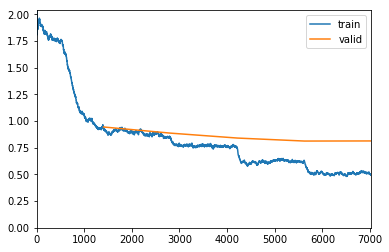

In [18]:
learner.fit_one_cycle(5, 5e-3)

## สำเร็จแล้ว ##

เพียงแค่เวลา 1 นาที เราเทรน Model เรียบร้อย เราจะมาดูผลลัพธ์กัน


In [19]:
learner.save("06a-collab-filter")

In [20]:
learner.load("06a-collab-filter");

# 7. ดูผลลัพธ์

## ดูโมเดล 

เราจะได้ Embeding และ Bias ออกมา 2 ชุด สำหรับ User และ Item (Movie) ขนาดเท่ากับ จำนวนข้อมูล x n_factors

In [21]:
learner.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1654, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

## ดูรีวิวหนัง 

* หนังที่มีคนรีวิวเกิน 1000 คน
* เรียงลำดับตามคะแนนเฉลี่ย มากไปน้อย 1000 เรื่อง
* แสดง 10 เรื่อง ที่มีคะแนนเฉลี่ยมากที่สุด

In [22]:
g = dataframe_rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

## ตีความจาก Bias ของ Movie Embeding 

In [23]:
movie_bias = learner.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [24]:
mean_ratings = dataframe_rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [25]:
item0 = lambda o:o[0]

In [26]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3607),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3053), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2796),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2699), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2603), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2575), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2546), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2483), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2393), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.2388), 'Showgirls (1995)', 1.9565217391304348),
 (tensor(-0.2339), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2213), 'Beautician and the Beast, The (1997)', 2.313953488372093),
 (tensor(-0.2182), 'Grease 2 (1982)', 2.0),
 (tensor(-0.2146), 'Beverly Hills Ninja (1997)', 2.3125),
 (tensor(-0.2067), "Stephen King's The Lang

In [27]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.5876), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5742), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5718), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5454), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5396), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5208), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5090), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5045), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.5020), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4813), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4703), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.4678), 'To Kill a Mockingbird (1962)', 4.292237442922374),
 (tensor(0.4602), 'Apt Pupil (1998)', 4.1),
 (tensor(0.4521), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.4421), 'Boot, Das (1981)', 4.203980099502488)]

## ตีความจาก Weight ของ Movie Embeding 

In [28]:
movie_weight = learner.weight(top_movies, is_item=True)
movie_weight.shape

torch.Size([1000, 50])

In [29]:
movie_pca = movie_weight.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [30]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [31]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.0685), 'Wrong Trousers, The (1993)'),
 (tensor(1.0490), 'When We Were Kings (1996)'),
 (tensor(1.0445), 'Casablanca (1942)'),
 (tensor(1.0096), 'Lawrence of Arabia (1962)'),
 (tensor(1.0080), 'Third Man, The (1949)'),
 (tensor(1.0059), 'Chinatown (1974)'),
 (tensor(1.0007), 'Close Shave, A (1995)'),
 (tensor(0.9816), '12 Angry Men (1957)'),
 (tensor(0.9750), 'Godfather, The (1972)'),
 (tensor(0.9653), 'Some Folks Call It a Sling Blade (1993)')]

In [32]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.2761), 'Home Alone 3 (1997)'),
 (tensor(-1.2665), 'Jungle2Jungle (1997)'),
 (tensor(-1.2409), "McHale's Navy (1997)"),
 (tensor(-1.1973), 'Leave It to Beaver (1997)'),
 (tensor(-1.1711), 'Congo (1995)'),
 (tensor(-1.1342), 'Bio-Dome (1996)'),
 (tensor(-1.1320), 'Free Willy 3: The Rescue (1997)'),
 (tensor(-1.1289), 'D3: The Mighty Ducks (1996)'),
 (tensor(-1.0726), 'Children of the Corn: The Gathering (1996)'),
 (tensor(-1.0618), 'Flipper (1996)')]

In [33]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [34]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.8843), 'Keys to Tulsa (1997)'),
 (tensor(0.8703), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(0.8038), 'Clockwork Orange, A (1971)'),
 (tensor(0.8031), 'Trainspotting (1996)'),
 (tensor(0.7647), 'Beavis and Butt-head Do America (1996)'),
 (tensor(0.7601), 'Stupids, The (1996)'),
 (tensor(0.7573), 'Brazil (1985)'),
 (tensor(0.7556), 'Very Brady Sequel, A (1996)'),
 (tensor(0.7503), 'Dead Man (1995)'),
 (tensor(0.7408), 'Spice World (1997)')]

In [35]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.1501), 'Braveheart (1995)'),
 (tensor(-1.0361), 'Titanic (1997)'),
 (tensor(-1.0171), 'Raiders of the Lost Ark (1981)'),
 (tensor(-0.9098), "It's a Wonderful Life (1946)"),
 (tensor(-0.8737), 'Affair to Remember, An (1957)'),
 (tensor(-0.8566), 'Independence Day (ID4) (1996)'),
 (tensor(-0.8415), "Mr. Holland's Opus (1995)"),
 (tensor(-0.8355), 'American President, The (1995)'),
 (tensor(-0.8309), 'Sleepless in Seattle (1993)'),
 (tensor(-0.8255), 'Pretty Woman (1990)')]

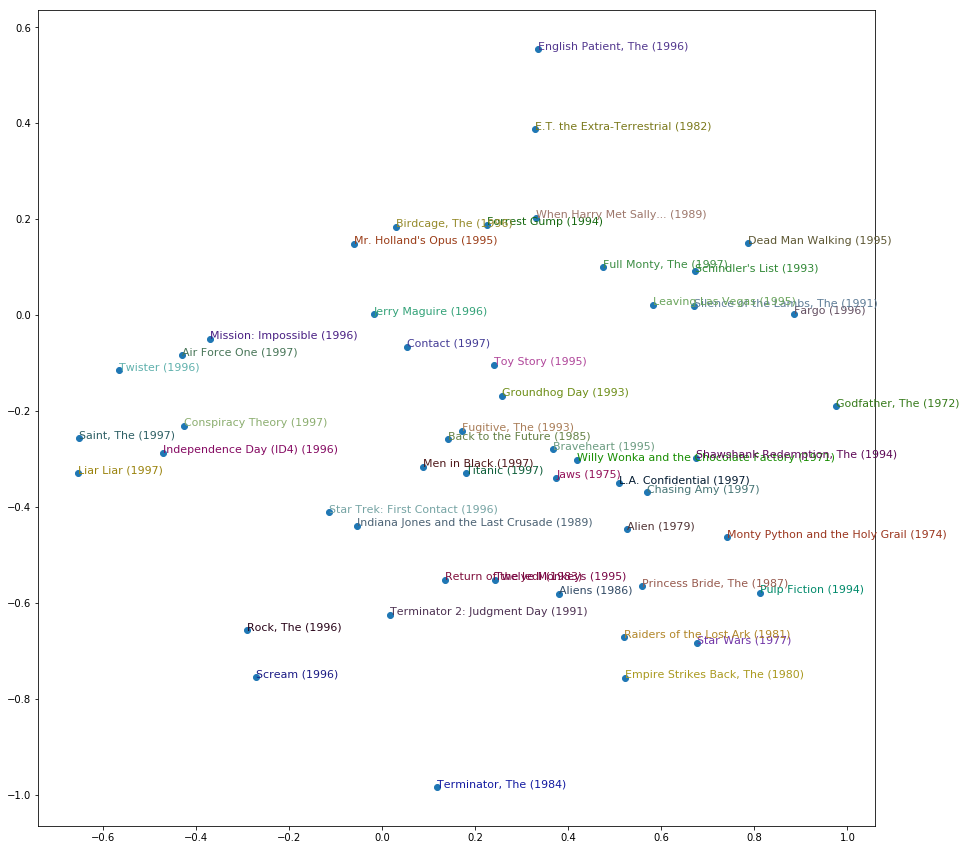

In [36]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

# 9. สรุป

1. 

# Credit 

* [FastAI: Practical Deep Learning for Coders, v3 - Lesson 4](https://course.fast.ai/videos/?lesson=4)
* [Movielens-100k](https://grouplens.org/datasets/movielens/100k/)
* F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4, Article 19 (December 2015), 19 pages. DOI=http://dx.doi.org/10.1145/2827872